In [1]:
from __future__ import print_function
from pymongo import MongoClient
from collections import Counter
from collections import defaultdict
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
from tqdm import tqdm

## Assumptions

- Products do not change, but users change
  - e.g. Pepsi was Pepsi in 2017 and in 2018. However, I may have liked Pepsi in 2017, but I am now moved on to a healthier drink
- Time to repurchase matters
  - e.g. Suppose Product A is repurchased almost every "week", and Product B is repurchased almost every "year". These two repurchase behaviors are not the same.
- Users and products have their inherent biases
  - e.g. Some users are just heavy users to begin with. Some products are just poopular to begin with.
- A user can be expressed with a mixture of static and dynamic states

## Objective Function

In [2]:
%%latex
\begin{align}
&\min_{\mathbf{u}, \mathbf{v}, \alpha} \sum_{i, t_i, j} ( y_{i,t_i,j} - \mathbf{u}_{i,t_i}^T \mathbf{v}_{j} - \alpha_i - \alpha_j )^2 + C_u ||\mathbf{u}_{i,t_i}-\mathbf{u}_{i,t_i-1}||^2 + C_v ||\mathbf{v}_{j}||^2  \\
&\text{where}\quad \mathbf{u}_{i,0} = 0
\end{align}

<IPython.core.display.Latex object>

## Iterative Solution

In [3]:
%%latex
\begin{align}
\mathbf{u}_{i, t_i} &= (\mathbf{V}_{i,t_i}^T \mathbf{V}_{i,t_i} + C_u \mathbf{I})^{-1} (\mathbf{V}_{i,t_i}^T \mathbf{y}_{i,t_i} + C_u \mathbf{u}_{i, t_i-1})\\
\mathbf{v}_j &= (\mathbf{U}_j^T \mathbf{U}_j + C_v \mathbf{I})^{-1}\mathbf{U}_j^T \mathbf{y}_j\\
\alpha_i &= \text{np.mean}(\mathbf{y}_i - \mathbf{u}_i^T \mathbf{V}_i)\\
\alpha_j &= \text{np.mean}(\mathbf{y}_j - \mathbf{U}_j^T \mathbf{v}_j)
\end{align}

<IPython.core.display.Latex object>

## Implementation

In [4]:
# parameters
n_max = 3000
m_max = 50
C_u = 0.01
C_v = 0.01
T = 5
D = 3

In [5]:
client = MongoClient()
db = client.instacart

In [6]:
user_lst = []
prod_lst = []
for doc in db.orders.find().limit(n_max):
    user_lst.append(doc["user_id"])
    prod_lst += [x for y in doc["orders"] for x in y["products"]]
prod_cnt = Counter(prod_lst)

In [7]:
user_set = {x for x in user_lst}
prod_set = {x for x, cnt in prod_cnt.most_common(m_max)}

In [8]:
Y = {} # Y[i][t][j]
Z = {} # Z[j][i][t]
for doc in db.orders.find().limit(n_max):
    i = doc["user_id"]
    orders = doc["orders"]
    orders = [x for x in orders if len(prod_set.intersection(x["products"]))>0]
    if len(orders) < 2:
        user_set.discard(i)
        continue
    t_end = max(1, len(orders)-T-1)
    for t in range(t_end):
        p = Counter([x for y in orders[t:t+T] for x in y["products"]
                    if x in prod_set])
        for j, y_ijt_unnorm in p.items():
            y_ijt = (y_ijt_unnorm+0.0)/T
            if i not in Y:
                Y[i] = {}
            if t not in Y[i]:
                Y[i][t] = {}
            if j not in Z:
                Z[j] = {}
            if i not in Z[j]:
                Z[j][i] = {}
            Y[i][t][j] = y_ijt
            Z[j][i][t] = y_ijt

In [14]:
A_u = {}
A_v = {}
U = {} # U[i][t]
V = {} # V[j]
np.random.seed(1)
for i, y_i in Y.items():
    U[i] = {}
    A_u[i] = 0
    for t, y_it in y_i.items():
        U[i][t] = np.random.rand(D)/D
for j in prod_set:
    A_v[j] = 0
    V[j] = np.random.rand(D)/D

In [15]:
def update_alpha_u(Y, U, V, A_u, A_v):
    for i, u_i in U.items():
        t_max = len(u_i.keys())
        n_cum = 0
        a_cum = 0
        y_i = Y[i]
        for t in range(t_max):
            j_seq = [j for j in y_i[t].keys()]
            n_it = len(j_seq)
            y_it = np.zeros(n_it)
            v_it = np.zeros((n_it, D))
            for j_idx, j in enumerate(j_seq):
                y_it[j_idx] = y_i[t][j] - A_v[j]
                v_it[j_idx,:] = V[j]
            a_cum += np.sum(y_it - np.dot(v_it, u_i[t]))
            n_cum += n_it
        A_u[i] = a_cum/n_cum

def update_alpha_v(Z, U, V, A_u, A_v):
    for j in V.keys():
        v_j = V[j]
        y_j = []
        for i, z_ji in Z[j].items():
            for t, z_jit in z_ji.items():
                y_j.append(z_jit - A_u[i])
        n_j = len(y_j)
        y_j = np.array(y_j)                    
        u_j = np.zeros((n_j, D))
        u_idx = 0
        for i, z_ji in Z[j].items():
            for t, z_jit in z_ji.items():
                u_j[u_idx,:] = U[i][t]
                u_idx += 1
        A_v[j] = np.mean(y_j - np.dot(u_j, v_j))

def update_u_it(y_i, u_i, V, t, A_u_i, A_v):
    u_curr = u_i[t]
    u_prev = np.zeros(D)
    if t > 0:
        u_prev = u_i[t-1]
    if t not in y_i:
        print(y_i, u_i, t)
    j_seq = [j for j in y_i[t].keys()]
    n_it = len(j_seq)
    y_it = np.zeros(n_it)
    v_it = np.zeros((n_it, D))
    I = np.diag(np.ones(D))
    for j_idx, j in enumerate(j_seq):
        y_it[j_idx] = y_i[t][j] - A_u_i - A_v[j]
        v_it[j_idx,:] = V[j]  
    out1 = np.linalg.inv(np.dot(v_it.T, v_it) + C_u * I)
    out2 = np.dot(v_it.T, y_it) + C_u * u_prev
    out = np.dot(out1, out2)
    return out
    
def update_u(Y, U, V, A_u, A_v):
    for i, u_i in U.items():
        t_max = len(u_i.keys())
        for t in range(t_max):
            U[i][t] = update_u_it(Y[i], u_i, V, t, A_u[i], A_v)
            
def update_v(Z, U, V, A_u, A_v):
    I = np.diag(np.ones(D))
    for j in V.keys():
        v_j = V[j]
        A_v_j = A_v[j]
        y_j = []
        for i, z_ji in Z[j].items():
            for t, z_jit in z_ji.items():
                y_j.append(z_jit - A_u[i] - A_v_j)
        n_j = len(y_j)
        y_j = np.array(y_j)                    
        u_j = np.zeros((n_j, D))
        u_idx = 0
        for i, z_ji in Z[j].items():
            for t, z_jit in z_ji.items():
                u_j[u_idx,:] = U[i][t]
                u_idx += 1
        out1 = np.linalg.inv(np.dot(u_j.T, u_j)+C_v*I)
        out2 = np.dot(u_j.T, y_j)
        V[j] = np.dot(out1, out2)
        
def loss_function(Y, U, V, A_u, A_v):
    loss = 0
    for i, y_i in Y.items():
        A_u_i = A_u[i]
        for t, y_it in y_i.items():
            u_prev = np.zeros(D)
            if t > 0:
                u_prev = U[i][t-1]
            dU = (U[i][t] - u_prev)
            dU_norm = np.dot(dU.T, dU)
            loss += C_u * dU_norm
            for j, y_itj in y_it.items():
                loss += (y_itj - np.dot(U[i][t].T, V[j]) - A_u_i - A_v[j])**2
    for j, v_j in V.items():
        loss += C_v * np.dot(v_j.T, v_j)
    return loss

In [17]:
num_iteration = 50
loss = []
for k in tqdm(range(num_iteration)):
    update_u(Y, U, V, A_u, A_v)
    update_v(Z, U, V, A_u, A_v)
    update_alpha_u(Y, U, V, A_u, A_v)
    update_alpha_v(Z, U, V, A_u, A_v)
    loss.append(loss_function(Y, U, V, A_u, A_v))

100%|██████████| 50/50 [02:19<00:00,  2.79s/it]


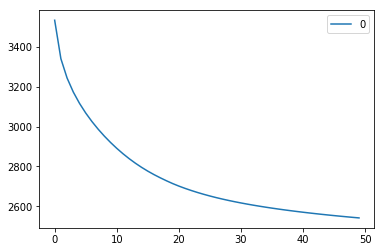

In [18]:
pd.DataFrame(loss).plot()

In [19]:
V_df = pd.DataFrame([[k] + v.tolist() for k, v in V.items()])
V_df

,0,1,2,3
0,19057 Organic Large Extra Fancy Fuji Apple,0.618708,-0.181971,0.052072
1,45007 Organic Zucchini,0.119361,0.137868,0.118286
2,27845 Organic Whole Milk,0.705270,0.038011,-0.547867
3,16797 Strawberries,0.329788,0.061539,-0.133399
4,47626 Large Lemon,-0.061681,0.260702,0.240618
5,47209 Organic Hass Avocado,0.157246,0.183977,0.478130
6,5876 Organic Lemon,0.069466,0.142574,0.124197
7,45066 Honeycrisp Apple,0.020097,0.604766,-0.297205
8,13176 Bag of Organic Bananas,0.341039,0.447515,0.035754
9,49683 Cucumber Kirby,-0.186568,0.336790,0.159682


In [20]:
A_v

{u'12341 Hass Avocados': -0.13634422867732154,
 u'13176 Bag of Organic Bananas': -0.18502875891746998,
 u'16797 Strawberries': 0.068442588379525993,
 u'17794 Carrots': 0.05865368243935036,
 u'19057 Organic Large Extra Fancy Fuji Apple': 0.0087285383504329996,
 u'19660 Spring Water': 0.19124594252176738,
 u'21137 Organic Strawberries': -0.02200801971758649,
 u'21616 Organic Baby Arugula': 0.13391209640376273,
 u'21903 Organic Baby Spinach': -0.021980672649422679,
 u'21938 Green Bell Pepper': 0.059082884960427365,
 u'22035 Organic Whole String Cheese': 0.15792664239269399,
 u'22935 Organic Yellow Onion': 0.080545680807116382,
 u'24184 Red Peppers': 0.12240991374339852,
 u'24838 Unsweetened Almondmilk': -0.11762713044384746,
 u'24852 Banana': -0.21771485122038103,
 u'24964 Organic Garlic': 0.09897247720358783,
 u'26209 Limes': -0.042657895872162947,
 u'26604 Organic Blackberries': 0.025816746782074237,
 u'27086 Half & Half': 0.067358809388747401,
 u'27104 Fresh Cauliflower': 0.08896529457

In [25]:
user_lst = list(user_set)
user_id = user_lst[1]
print(U[user_id])

{0: array([ 1.76747966,  1.12677264,  0.956423  ]), 1: array([ 1.43323242,  1.45452948,  0.85934701]), 2: array([ 1.26739904,  1.89673022,  0.75342457]), 3: array([ 1.00666234,  1.50777556,  0.54154968]), 4: array([ 0.8600593 ,  1.29784776,  0.50096552]), 5: array([ 0.9111528 ,  1.44575818,  0.48603542]), 6: array([ 1.10250009,  1.31696104,  0.57640403]), 7: array([ 1.2577385 ,  1.46890834,  1.40203335]), 8: array([ 1.60315268,  0.84807476,  1.44729102]), 9: array([ 1.82452615,  1.03534091,  1.29701974]), 10: array([ 1.56928031,  0.93925098,  1.3641207 ]), 11: array([ 1.55036309,  1.03163326,  1.15622926])}


In [26]:
Y[user_id]

{0: {u'21137 Organic Strawberries': 0.6,
  u'24838 Unsweetened Almondmilk': 0.6,
  u'24964 Organic Garlic': 0.2,
  u'26604 Organic Blackberries': 0.2,
  u'27086 Half & Half': 0.2,
  u'27845 Organic Whole Milk': 0.8,
  u'47209 Organic Hass Avocado': 1.0},
 1: {u'21137 Organic Strawberries': 0.8,
  u'24838 Unsweetened Almondmilk': 0.6,
  u'24964 Organic Garlic': 0.2,
  u'26604 Organic Blackberries': 0.2,
  u'27086 Half & Half': 0.2,
  u'27845 Organic Whole Milk': 0.6,
  u'47209 Organic Hass Avocado': 1.0,
  u'8518 Organic Red Onion': 0.2},
 2: {u'21137 Organic Strawberries': 1.0,
  u'24838 Unsweetened Almondmilk': 0.6,
  u'24964 Organic Garlic': 0.2,
  u'27086 Half & Half': 0.2,
  u'27845 Organic Whole Milk': 0.6,
  u'47209 Organic Hass Avocado': 1.0,
  u'8518 Organic Red Onion': 0.2},
 3: {u'13176 Bag of Organic Bananas': 0.2,
  u'21137 Organic Strawberries': 1.0,
  u'24838 Unsweetened Almondmilk': 0.4,
  u'24964 Organic Garlic': 0.2,
  u'27845 Organic Whole Milk': 0.6,
  u'42265 Organi

In [30]:
history = list(set([x for t, y_it in Y[user_id].items() for x in y_it.keys()]))
t_max = np.max(U[i].keys())
out = Counter()
for j in history:
    score_j = np.dot(U[i][t_max].T, V[j])
    out[j] = score_j
out.most_common()

[(u'13176 Bag of Organic Bananas', 1.164306460656948),
 (u'28985 Michigan Organic Kale', 0.95570564843095851),
 (u'21137 Organic Strawberries', 0.75583067105535084),
 (u'47209 Organic Hass Avocado', 0.74157259975026879),
 (u'24838 Unsweetened Almondmilk', 0.72703355044277318),
 (u'27845 Organic Whole Milk', 0.71931569533994555),
 (u'27086 Half & Half', 0.56894108022793866),
 (u'26604 Organic Blackberries', 0.42174396036088868),
 (u'43961 Organic Peeled Whole Baby Carrots', 0.36135886943924639),
 (u'39275 Organic Blueberries', 0.35088292309331126),
 (u'24964 Organic Garlic', 0.2614016760205321),
 (u'8518 Organic Red Onion', 0.23043557148457461),
 (u'42265 Organic Baby Carrots', 0.2236765708414879)]